In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
import matplotlib.pyplot as plt

## Импорт и предобработка данных

**Функция для импорта датасетов**

In [2]:
def import_dataset(filepath):
    
    df = pd.read_csv(filepath, sep = ';', usecols = ['<DATE>', '<CLOSE>'], parse_dates = ['<DATE>'])
    name = filepath[filepath.rindex('/') + 1:len(filepath) - 4]
    df.rename(columns = {'<DATE>':'Дата', '<CLOSE>':name}, inplace = True)
    
    return df

**Данные о котировках взяты за период с 1 января 2010 года по 1 января 2020 года, таймфрейм - день**

**Сайт - mfd.ru, раздел МосБиржа Акции и ПИФы, тикеры: Сбербанк, ГАЗПРОМ ао, ЛУКОЙЛ, ГМКНорНик**

In [3]:
files = ('./Датасеты/Сбербанк.txt', './Датасеты/Газпром.txt', './Датасеты/Лукойл.txt', './Датасеты/НорНикель.txt')
df = import_dataset(files[0])

for filepath in files[1:]:
    
    df = df.merge(right = import_dataset(filepath), how = 'inner', on = 'Дата')
    
df

,Дата,Сбербанк,Газпром,Лукойл,НорНикель
0,2010-11-01,86.69,194.50,1750.98,4695.40
1,2010-12-01,85.00,191.80,1719.82,4640.06
2,2010-01-13,86.61,189.30,1709.44,4654.14
3,2010-01-14,87.55,190.83,1726.80,4892.94
4,2010-01-15,88.15,187.86,1731.95,4884.62
...,...,...,...,...,...
2506,2019-12-24,248.67,254.87,6080.50,19630.00
2507,2019-12-25,248.04,253.25,6081.00,19890.00
2508,2019-12-26,248.24,254.10,6085.00,19220.00
2509,2019-12-27,252.06,257.11,6150.00,19292.00


**Наш исходный датасет готов. Он содержит 2511 строк и 5 столбцов (4 из которых - котировки). Проведем предобработку данных**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2511 entries, 0 to 2510
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Дата       2511 non-null   datetime64[ns]
 1   Сбербанк   2511 non-null   float64       
 2   Газпром    2511 non-null   float64       
 3   Лукойл     2511 non-null   float64       
 4   НорНикель  2511 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 117.7 KB


In [5]:
df.isnull().sum()

Дата         0
Сбербанк     0
Газпром      0
Лукойл       0
НорНикель    0
dtype: int64

**В датасете отсутствуют пустые значения. Все данные по котировкам имеют тип float64, это означает две вещи. Первое: нет ошибок в шкалах (иначе был бы тип object). Второе: данные непрерывные и измеряются по числовой шкале. Задача машинного обучения - регрессия. Теперь нужно избавить датасет от выбросов**

In [6]:
def delete_outliers(df):
        
    new_df = pd.DataFrame({'Дата': df['Дата']})

    for col in df.columns[1:]:

        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1

        new_df = new_df.merge(pd.DataFrame({'Дата': df['Дата'], col: df.query(f"@q1 - 1.5*@iqr < {col} < @q3 + 1.5*@iqr")[col]}),
                              how = 'inner', on = 'Дата')
        
    return new_df.dropna()

In [7]:
df = delete_outliers(df)
df

,Дата,Сбербанк,Газпром,Лукойл,НорНикель
0,2010-11-01,86.69,194.50,1750.98,4695.40
1,2010-12-01,85.00,191.80,1719.82,4640.06
2,2010-01-13,86.61,189.30,1709.44,4654.14
3,2010-01-14,87.55,190.83,1726.80,4892.94
4,2010-01-15,88.15,187.86,1731.95,4884.62
...,...,...,...,...,...
2252,2018-12-21,186.79,151.12,4930.00,13014.00
2253,2018-12-24,184.30,149.73,4909.00,12783.00
2254,2018-12-25,183.30,147.01,4810.00,12555.00
2255,2018-12-26,183.40,148.41,4829.50,12867.00


**Котировки акций Сбербанка - это эндогенная переменная нашей модели. Построим корреляционную матрицу для выявления статистической зависимости между ними и котировками остальных компаний**

In [8]:
df.corr()

,Сбербанк,Газпром,Лукойл,НорНикель
Сбербанк,1.000000,-0.250438,0.828547,0.627889
Газпром,-0.250438,1.000000,-0.319430,-0.265727
Лукойл,0.828547,-0.319430,1.000000,0.855792
НорНикель,0.627889,-0.265727,0.855792,1.000000


**Все котировки имеют статистическую связь с котировками акций Сбербанка, иначе бы их не было в матрице. Значит, не будем ничего убирать из рассмотрения**

**Датасет после предобработки содержит 2162 строки и 5 столбцов (4 из которых - котировки)**

**Разобьем датасет на две выборки: обучающую (70%) и тестовую (30%)**

In [9]:
X = df[df.columns[2:]].values
y = df[df.columns[1]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

**Мы рассмотрим пять методов регрессии: линейная, полиномиальная, гребневая (ридж), лассо, эластичная сеть**

## Множественная линейная регрессия

**Формула в общем виде: <i>y = b0 + b1 * x1 + b2 * x2 + ... + bn * xn</i>**

In [10]:
reg = LinearRegression()
reg.fit(X_train, y_train)

print(f'MSE train: {mse(y_train, reg.predict(X_train))}\nMSE test: {mse(y_test, reg.predict(X_test))}\n')
print(f'R^2 train: {r2(y_train, reg.predict(X_train))}\nR^2 test: {r2(y_test, reg.predict(X_test))}')

MSE train: 740.932787318931
MSE test: 617.6331277129914

R^2 train: 0.7039662238382216
R^2 test: 0.7301774033458164


**Коэффициенты детерминации говорят о хорошем качестве модели**

**Напишем универсальную функцию, которая будет выводить необходимую нам информацию о модели**

In [11]:
def summary(reg, X_train, y_train, X_test, y_test):

    print(f'MSE train: {mse(y_train, reg.predict(X_train))}\nMSE test: {mse(y_test, reg.predict(X_test))}\n')
    print(f'R^2 train: {r2(y_train, reg.predict(X_train))}\nR^2 test: {r2(y_test, reg.predict(X_test))}')
    
    y_train_pred = reg.predict(X_train)
    y_test_pred = reg.predict(X_test)

    plt.scatter(y_train_pred,  y_train_pred - y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_pred,  y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-4, xmax=4, lw=2, color='red')
    plt.xlim([-4, 4])
    plt.tight_layout()

## Шкалирование

**Для следующих методов регрессии (кроме полиномиальной) обязательно нужно провести шкалирование, иначе предикторы с высоким стандартным отклонением будут сильно штрафоваться**

In [12]:
X_train.std(), X_train.mean()

(3468.183270827367, 3429.8247962106193)

In [13]:
X_std = StandardScaler().fit_transform(X)
y_std = StandardScaler().fit_transform(y.reshape(-1, 1)).flatten()

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_std, y_std, test_size=0.3, random_state=0)

In [14]:
X_train_scaled.std(), X_train_scaled.mean()

(0.9971493966122479, 0.0033074748182482187)

**Шкалирование прошло успешно. Для адекватного сравнения методов построим модель множественной регрессии на шкалированных данных**

MSE train: 0.3038079727292749
MSE test: 0.2532508638197918

R^2 train: 0.7039662238382216
R^2 test: 0.7301774033458164


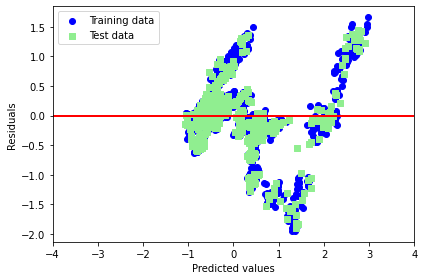

In [15]:
reg = LinearRegression()
reg.fit(X_train_scaled, y_train_scaled)

summary(reg, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

## Ридж регрессия

**В методах регрессии ридж, лассо и эластичная сеть присутствует параметр alpha, участвующий в вычислении значения штрафа. В данном методе применяется регуляризация L2**

MSE train: 0.3038080034726968
MSE test: 0.25324957295423367

R^2 train: 0.7039661938814987
R^2 test: 0.7301787786805005


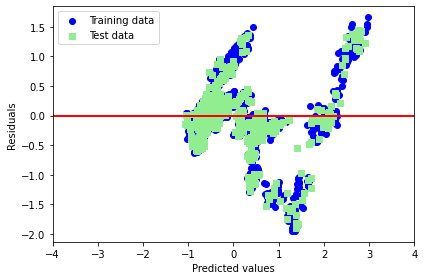

In [31]:
reg = Ridge(alpha = 0.1)
reg.fit(X_train_scaled, y_train_scaled)

summary(reg, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

**Показатели незначительно поменялись в лучшую сторону по сравнению с обычной линейной регрессией. Значения среднеквадратических ошибок уменьшились, а коэффициенты детерминации подросли**

## Регрессия лассо

**Регрессия лассо очень похожа на ридж регрессию, но здесь применяется регуляризация L1**

MSE train: 0.33964669761062094
MSE test: 0.2850227744613451

R^2 train: 0.6690445824996577
R^2 test: 0.6963264647915897


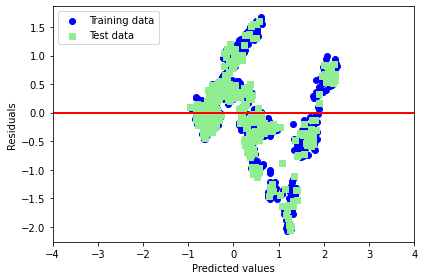

In [17]:
reg = Lasso(alpha = 0.1)
reg.fit(X_train_scaled, y_train_scaled)

summary(reg, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

**Показатели говорят о том, что эта модель хуже, чем две предыдущие**

## Регрессия "эластичная сеть"

**Эластичная сеть - комбинация L1 и L2 регуляризации в определенных пропорциях. Поэтому помимо параметра alpha здесь присутствует параметр l1_ratio, означающий долю регуляризации L1 в модели**

MSE train: 0.3331398516870518
MSE test: 0.2791621955658704

R^2 train: 0.6753849235787693
R^2 test: 0.702570536743103


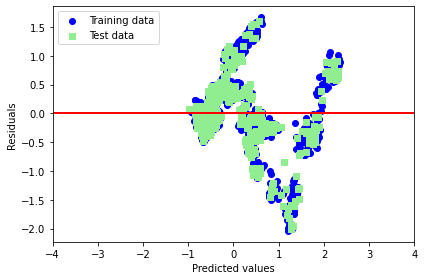

In [18]:
reg = ElasticNet(alpha = 0.1, l1_ratio = 0.1) # в данном случае чем меньше l1_ratio, тем точнее модель
reg.fit(X_train_scaled, y_train_scaled)

summary(reg, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

**По показателям эта модель лучше, чем лассо, но хуже, чем линейная и ридж регрессия**

## Полиномиальная регрессия

**В отличие от всех предыдущих методов, полиномиальная регрессия может быть нелинейной. Здесь всё зависит от степеней**

In [19]:
def PolynomialRegression(degree):
    
    return Pipeline([
        ('poly', PolynomialFeatures(degree = degree)),
        ('lin_reg', LinearRegression())    
    ])

MSE train: 0.3038079727292749
MSE test: 0.2532508638197917

R^2 train: 0.7039662238382216
R^2 test: 0.7301774033458164


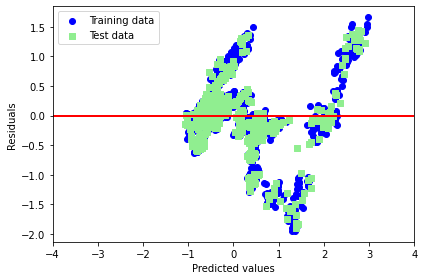

In [20]:
reg = PolynomialRegression(1) #полиномиальная регрессия в первой степени - это линейная регрессия
reg.fit(X_train_scaled, y_train_scaled)

summary(reg, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

MSE train: 0.13921088169821005
MSE test: 0.11224019690320942

R^2 train: 0.8643514104593456
R^2 test: 0.8804152494462922


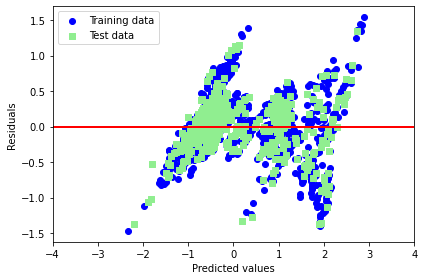

In [21]:
reg = PolynomialRegression(2) #вторая степень
reg.fit(X_train_scaled, y_train_scaled)

summary(reg, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

MSE train: 0.07177868746833195
MSE test: 0.059518624028337394

R^2 train: 0.930058070206994
R^2 test: 0.9365867131018448


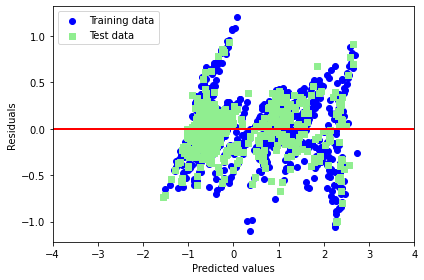

In [22]:
reg = PolynomialRegression(3) #третья степень
reg.fit(X_train_scaled, y_train_scaled)

summary(reg, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

MSE train: 0.04919367418934555
MSE test: 0.045512594328546485

R^2 train: 0.9520651515405708
R^2 test: 0.9515092418759317


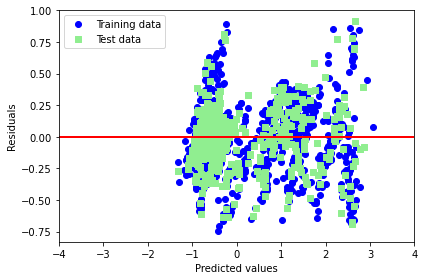

In [23]:
reg = PolynomialRegression(4) #четвертая степень
reg.fit(X_train_scaled, y_train_scaled)

summary(reg, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

MSE train: 0.03886832042315468
MSE test: 0.03990769033630919

R^2 train: 0.9621262879819622
R^2 test: 0.9574809085718408


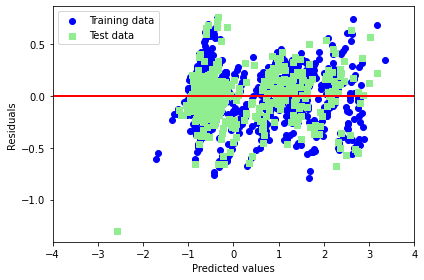

In [24]:
reg = PolynomialRegression(5) #пятая степень
reg.fit(X_train_scaled, y_train_scaled)

summary(reg, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

MSE train: 0.032894519501427626
MSE test: 0.042228530846661255

R^2 train: 0.9679472242431493
R^2 test: 0.9550082014565394


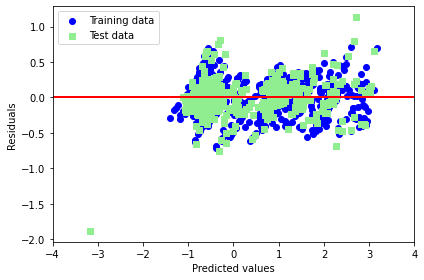

In [25]:
reg = PolynomialRegression(6) #шестая степень
reg.fit(X_train_scaled, y_train_scaled)

summary(reg, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

**Полиномиальная модель в пятой степени оптимальна, с дальнейшим повышением степени происходит переобучение, и точность снижается. У нее самые высокие коэффициенты детерминации и самые низкие MSE, значит, эта модель - самая точная. Кроме того, распределение остатков в данной модели больше стало походить на случайное, до этого оно напоминало нелинейный график**